<div style="text-align: center;">
  <img src="https://github.com/Hack-io-Data/Imagenes/blob/main/01-LogosHackio/logo_naranja@4x.png?raw=true" alt="esquema" />
</div>

# Preprocesamiento de Datos para un Modelo de Clasificación

Nuestro equipo de riesgo ha identificado la necesidad de construir un modelo de clasificación para detectar transacciones potencialmente fraudulentas o anómalas. El éxito de este modelo permitirá identificar patrones en los datos y reducir pérdidas económicas para nuestros clientes y la empresa. Tu trabajo para hoy será preparar los datos proporcionados para desarrollar un modelo de clasificación que prediga la probabilidad de que una transacción sea “Normal” o “Anómala”, basándose en las características de las transacciones. Dentro de las tareas que tienes que realizar hoy deben estar incluidas las siguientes: 


1. **Análisis exploratorio de datos (EDA):**

   - Visualizar la distribución de las principales variables.

   - Explorar relaciones entre las características y la variable objetivo (`TransactionStatus`).


2. **Limpieza de datos:**

   - Identificar y tratar valores nulos.

   - Eliminar duplicados si existen.

   - Asegurar que las variables tienen el tipo de dato correcto.

   - etc. 

3. **Transformación de variables:**

   - Normalizar o escalar variables numéricas según sea necesario.

   - Codificar variables categóricas con técnicas como One-Hot Encoding, Target Encoding u Ordinal Encoding, según corresponda.

   - Crear variables derivadas útiles, como:

     - Frecuencia de transacciones de cada cliente.

     - Diferencia de tiempo entre transacciones consecutivas.

     - Ratio entre el saldo posterior y el monto de la transacción.

## Datos Proporcionados

El archivo de datos que analizarán contiene transacciones reales registradas por una compañia. A continuación, se describen las principales columnas que deberán preprocesar:

| Columna               | Descripción                                                                                     |
|-----------------------|-------------------------------------------------------------------------------------------------|
| `transaction_id`      | Identificador único de la transacción.                                                         |
| `customer_id`         | Identificador único del cliente que realizó la transacción.                                    |
| `merchant_id`         | Identificador único del comercio donde se realizó la transacción.                              |
| `amount`              | Monto de la transacción (en la moneda correspondiente).                                        |
| `transaction_time`    | Fecha y hora exacta en la que ocurrió la transacción.                                          |
| `is_fraudulent`       | Indicador de si la transacción fue fraudulenta (1: Sí, 0: No).                                 |
| `card_type`           | Tipo de tarjeta utilizada para la transacción (Visa, MasterCard, American Express, Discover).  |
| `location`            | Ubicación (ciudad o región) donde se realizó la transacción.                                   |
| `purchase_category`   | Categoría de la compra (por ejemplo, Gas Station, Online Shopping, Retail, etc.).              |
| `customer_age`        | Edad del cliente en el momento de la transacción.                                              |
| `transaction_description` | Descripción breve de la transacción, usualmente incluye el comercio asociado.              |


In [2]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np
import os 
import sys
sys.path.append("../")
import seaborn as sns 
import matplotlib.pyplot as plt

In [3]:

# Importamos las clases creadas para hace el EDA
from src import soporte_logistica_preprocesamiento as sl
from src import soporte_encoding as se
from src import soporte_encoding_logistica as sc

# Ignorar warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore")

# Imputación de nulos usando métodos avanzados estadísticos
# -----------------------------------------------------------------------
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler, RobustScaler
from category_encoders import TargetEncoder

In [4]:
# leemos el dataframe
df = pd.read_csv("datos/financial_data.csv", index_col = 0)
df.head(2)

,customer_id,merchant_id,amount,transaction_time,is_fraudulent,card_type,location,purchase_category,customer_age,transaction_description
transaction_id,,,,,,,,,,
1,1082,2027,5758.59,2023-01-01 00:00:00,0,MasterCard,City-30,Gas Station,43,Purchase at Merchant-2027
2,1015,2053,1901.56,2023-01-01 00:00:01,1,Visa,City-47,Online Shopping,61,Purchase at Merchant-2053


In [5]:
# llamamos a la función para hacer el análisis exploratorio de datos, para familiarizarnos con la estructura de los datos
sl.exploracion_datos(df)

El número de filas es 10000 y el número de columnas es 10

----------

En este conjunto de datos tenemos 0 valores duplicados

----------

Los columnas con valores nulos y sus porcentajes son: 


Series([], dtype: float64)


----------

Las principales estadísticas de las variables númericas son:


,count,mean,std,min,25%,50%,75%,max
customer_id,10000.0,1051.272300,28.864062,1001.00,1026.000,1052.000,1076.0000,1100.00
merchant_id,10000.0,2050.486600,28.877801,2001.00,2025.000,2050.000,2076.0000,2100.00
amount,10000.0,4958.381617,2899.699675,10.61,2438.175,4943.945,7499.3125,9999.75
is_fraudulent,10000.0,0.506800,0.499979,0.00,0.000,1.000,1.0000,1.00
customer_age,10000.0,44.047500,15.321707,18.00,31.000,44.000,57.0000,70.00



----------

Las principales estadísticas de las variables categóricas son:


,count,unique,top,freq
transaction_time,10000,10000,2023-01-01 02:46:23,1
card_type,10000,4,Discover,2633
location,10000,50,City-7,223
purchase_category,10000,6,Travel,1694
transaction_description,10000,100,Purchase at Merchant-2016,120



----------

Las características principales del dataframe son:
<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   customer_id              10000 non-null  int64  
 1   merchant_id              10000 non-null  int64  
 2   amount                   10000 non-null  float64
 3   transaction_time         10000 non-null  object 
 4   is_fraudulent            10000 non-null  int64  
 5   card_type                10000 non-null  object 
 6   location                 10000 non-null  object 
 7   purchase_category        10000 non-null  object 
 8   customer_age             10000 non-null  int64  
 9   transaction_description  10000 non-null  object 
dtypes: float64(1), int64(4), object(5)
memory usage: 859.4+ KB


None

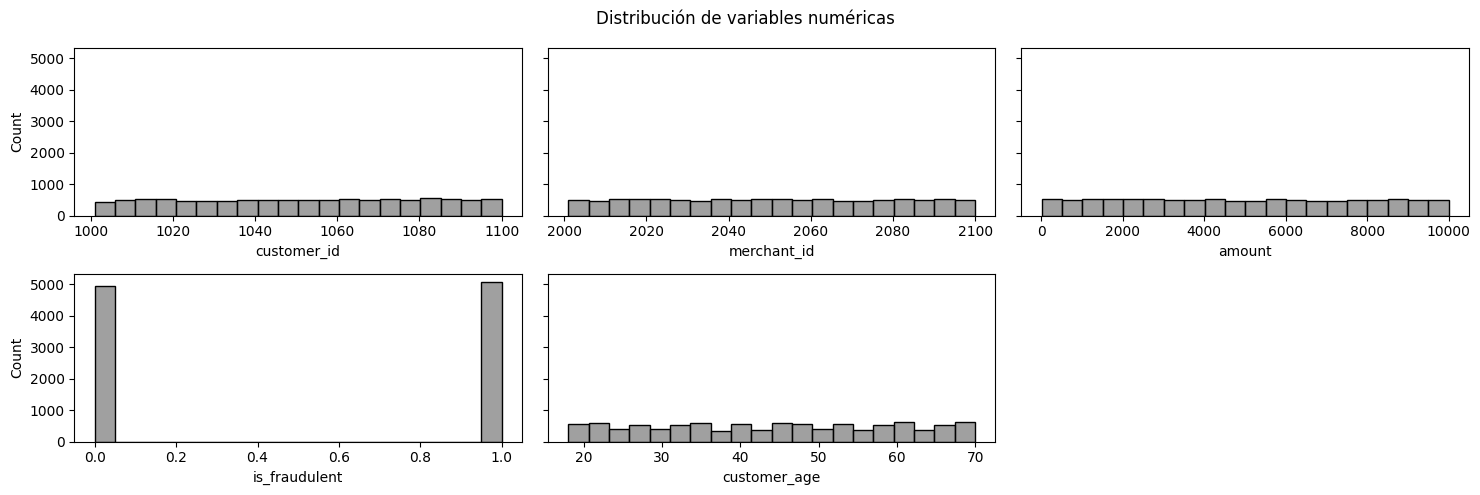

In [6]:
# Crear una instancia de la clase y llamar a los métodos
visualizador =sl.Visualizador(df)

# exploramos la distribución de las variables numéricas
visualizador.plot_numericas()

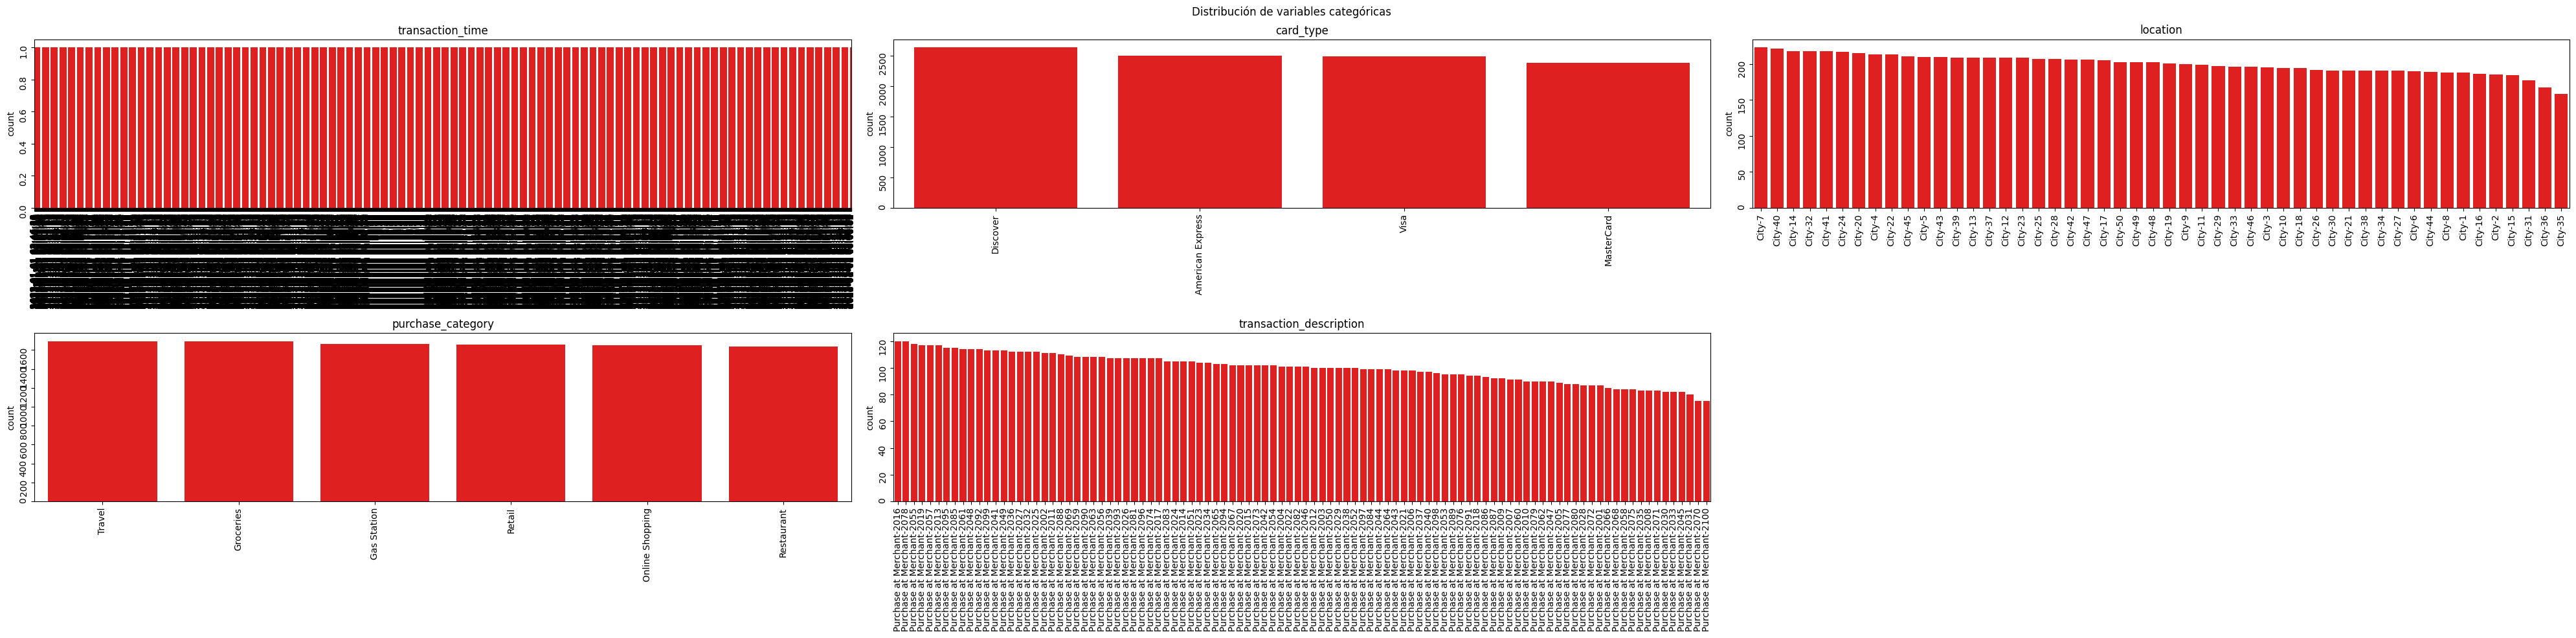

In [7]:
# evaluamos la distribución de las variables categóricas
visualizador.plot_categoricas(color = "red")

In [8]:
df.columns.unique()

Index(['customer_id', 'merchant_id', 'amount', 'transaction_time',
       'is_fraudulent', 'card_type', 'location', 'purchase_category',
       'customer_age', 'transaction_description'],
      dtype='object')

IndexError: index 9 is out of bounds for axis 0 with size 9

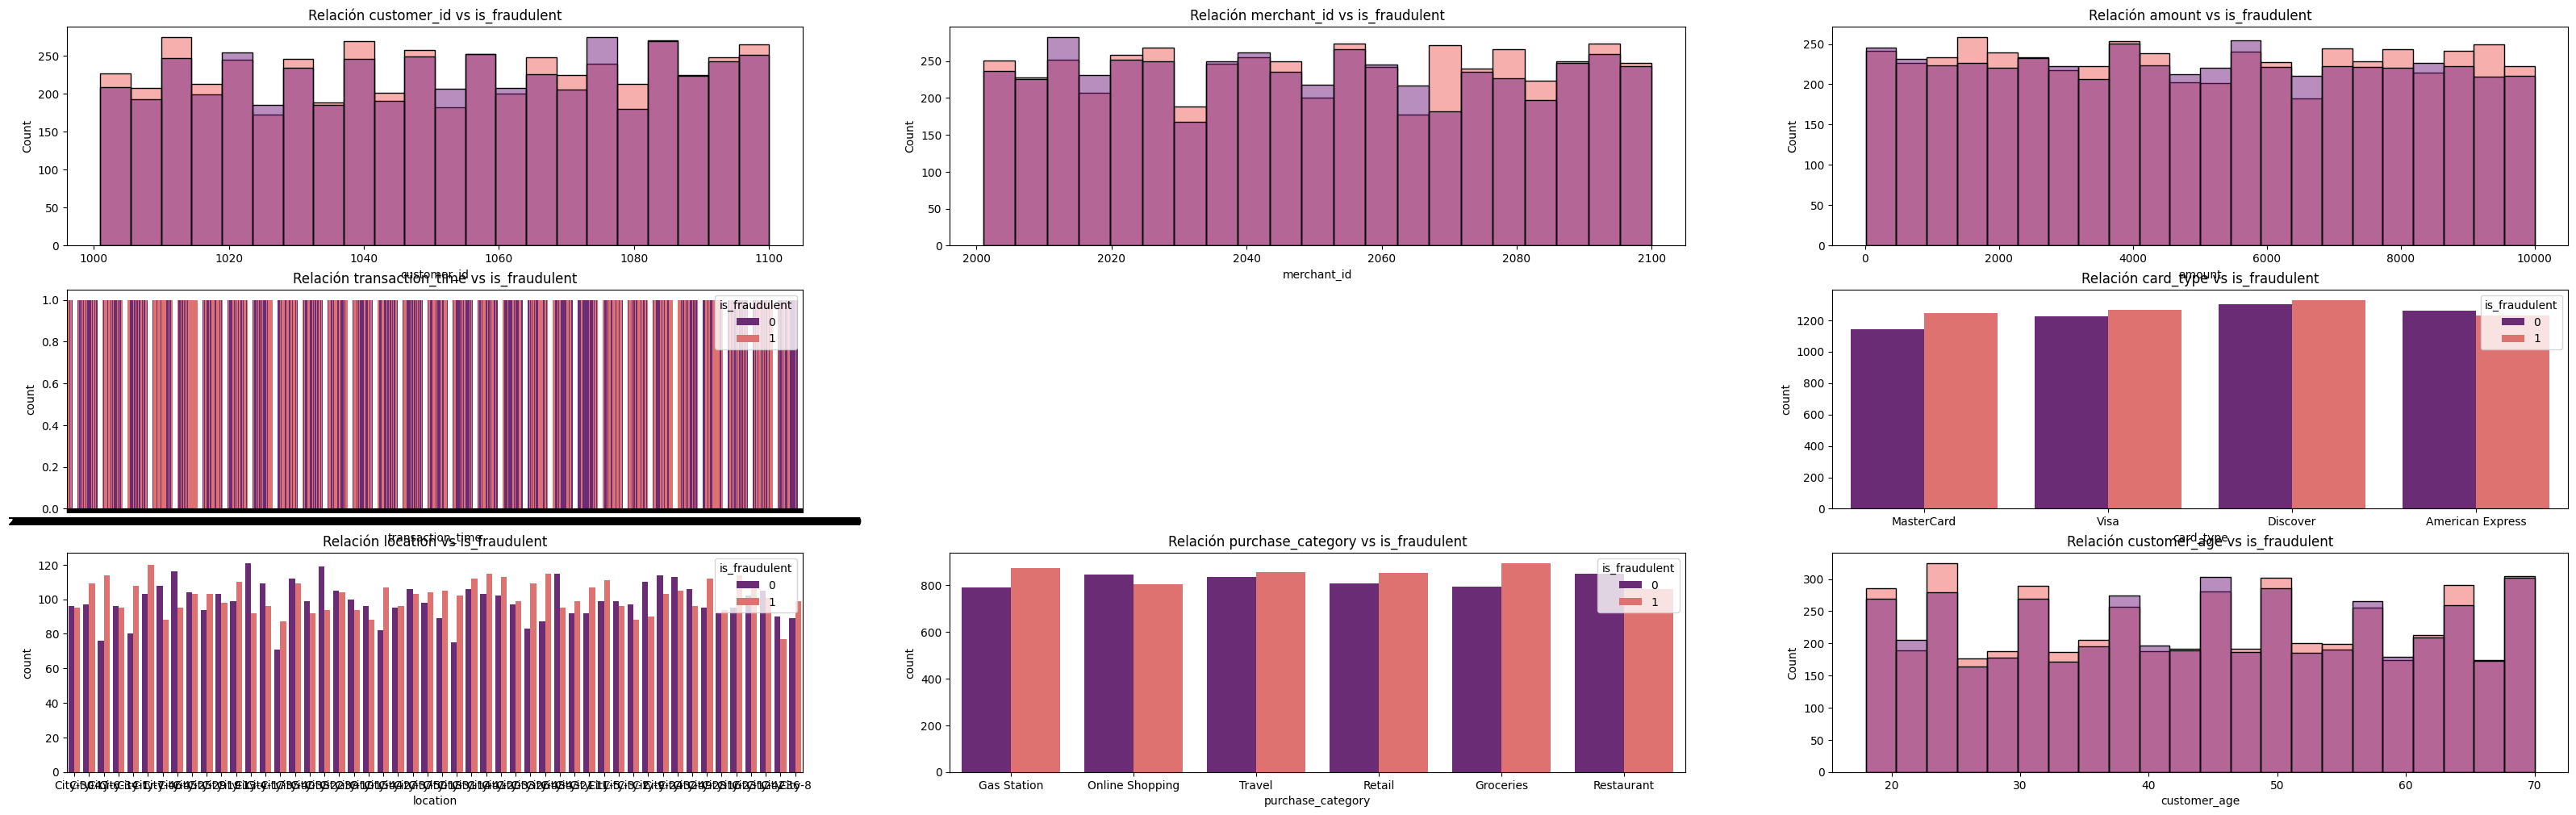

In [9]:
# evaluamos la relación entre las variables independientes y dependientes
visualizador.plot_relacion(vr = "is_fraudulent")

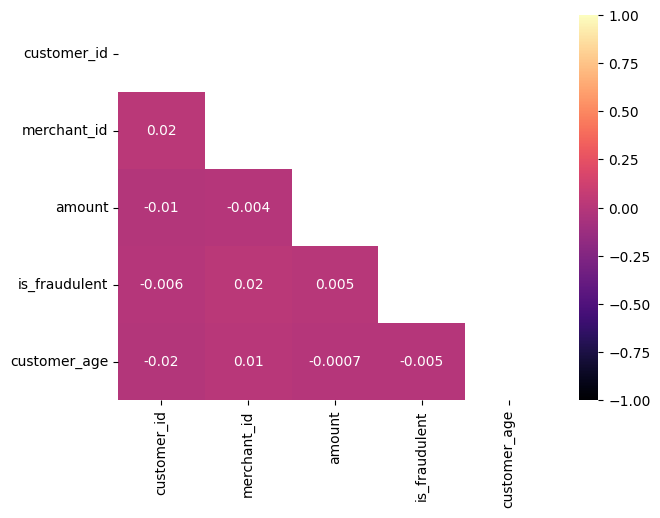

In [10]:
# evaluamos las correlaciones entre las variables numéricas
visualizador.correlacion()

In [11]:
columnas_numericas = df.select_dtypes(include=['number']).columns
columnas_numericas

Index(['customer_id', 'merchant_id', 'amount', 'is_fraudulent',
       'customer_age'],
      dtype='object')

In [12]:
escalador_estandar = StandardScaler()
datos_transf_estandar = escalador_estandar.fit_transform(df[['customer_id','merchant_id','amount','customer_age']])
df[['customer_id','merchant_id','amount','customer_age']]  = datos_transf_estandar          #Estandarizacion

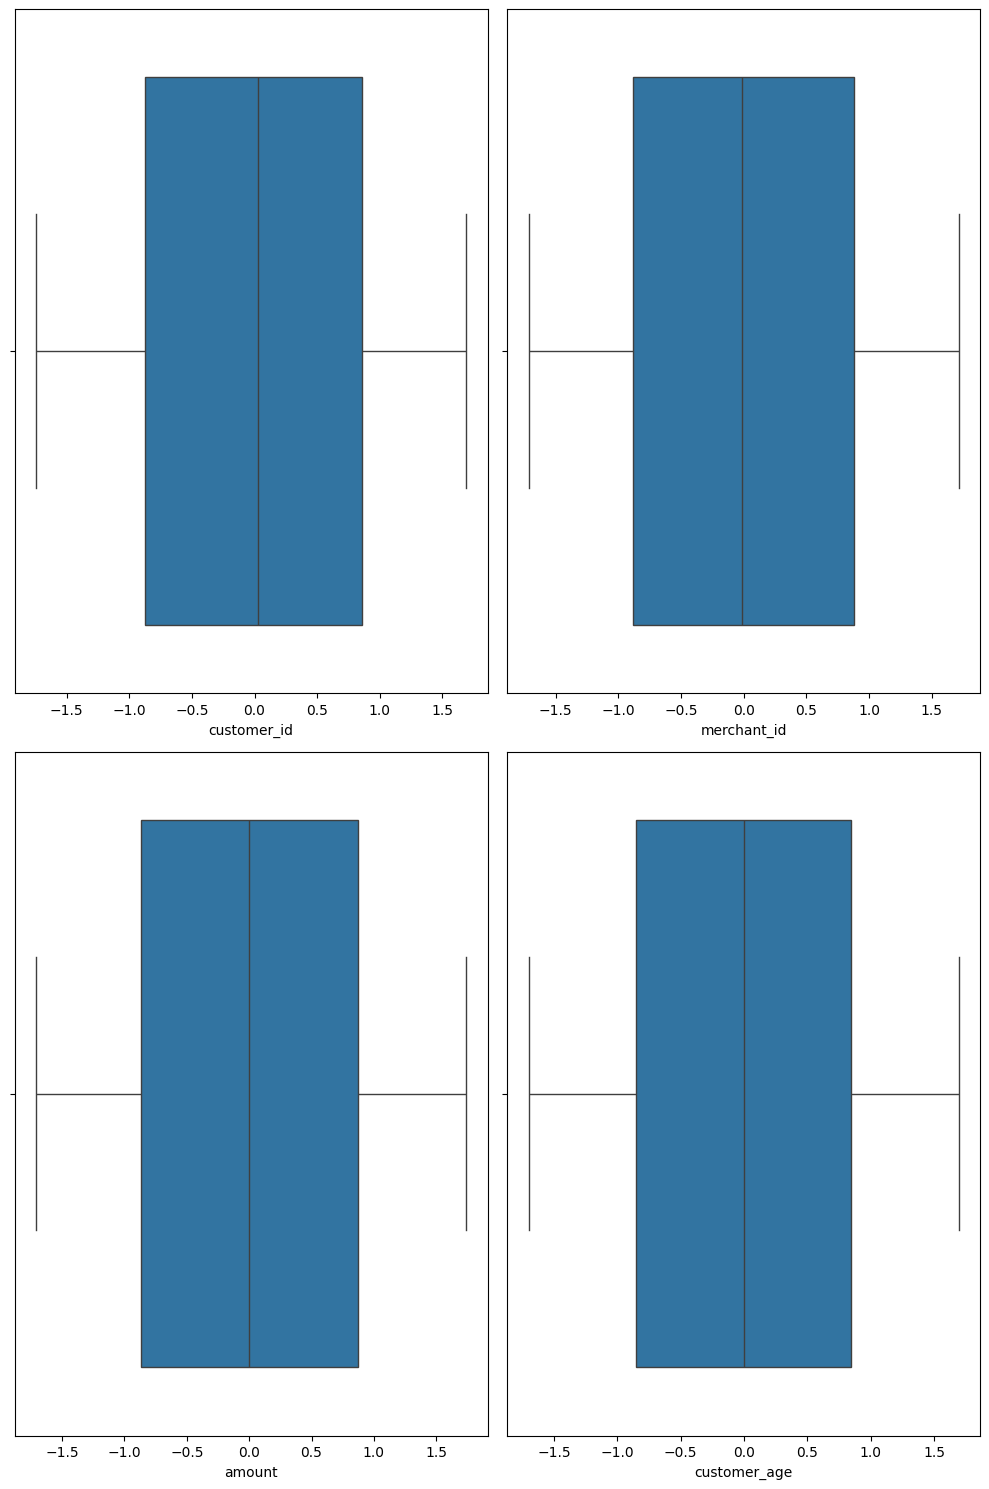

In [13]:
fig, axes = plt.subplots(nrows=2 , ncols=2, figsize = (10, 15) )

sns.boxplot(x = "customer_id", data = df, ax = axes[0][0])
sns.boxplot(x = "merchant_id", data = df, ax = axes[0][1])
sns.boxplot(x = "amount", data = df, ax = axes[1][0])
sns.boxplot(x = "customer_age", data = df, ax = axes[1][1])

plt.tight_layout()

IndexError: index 9 is out of bounds for axis 0 with size 9

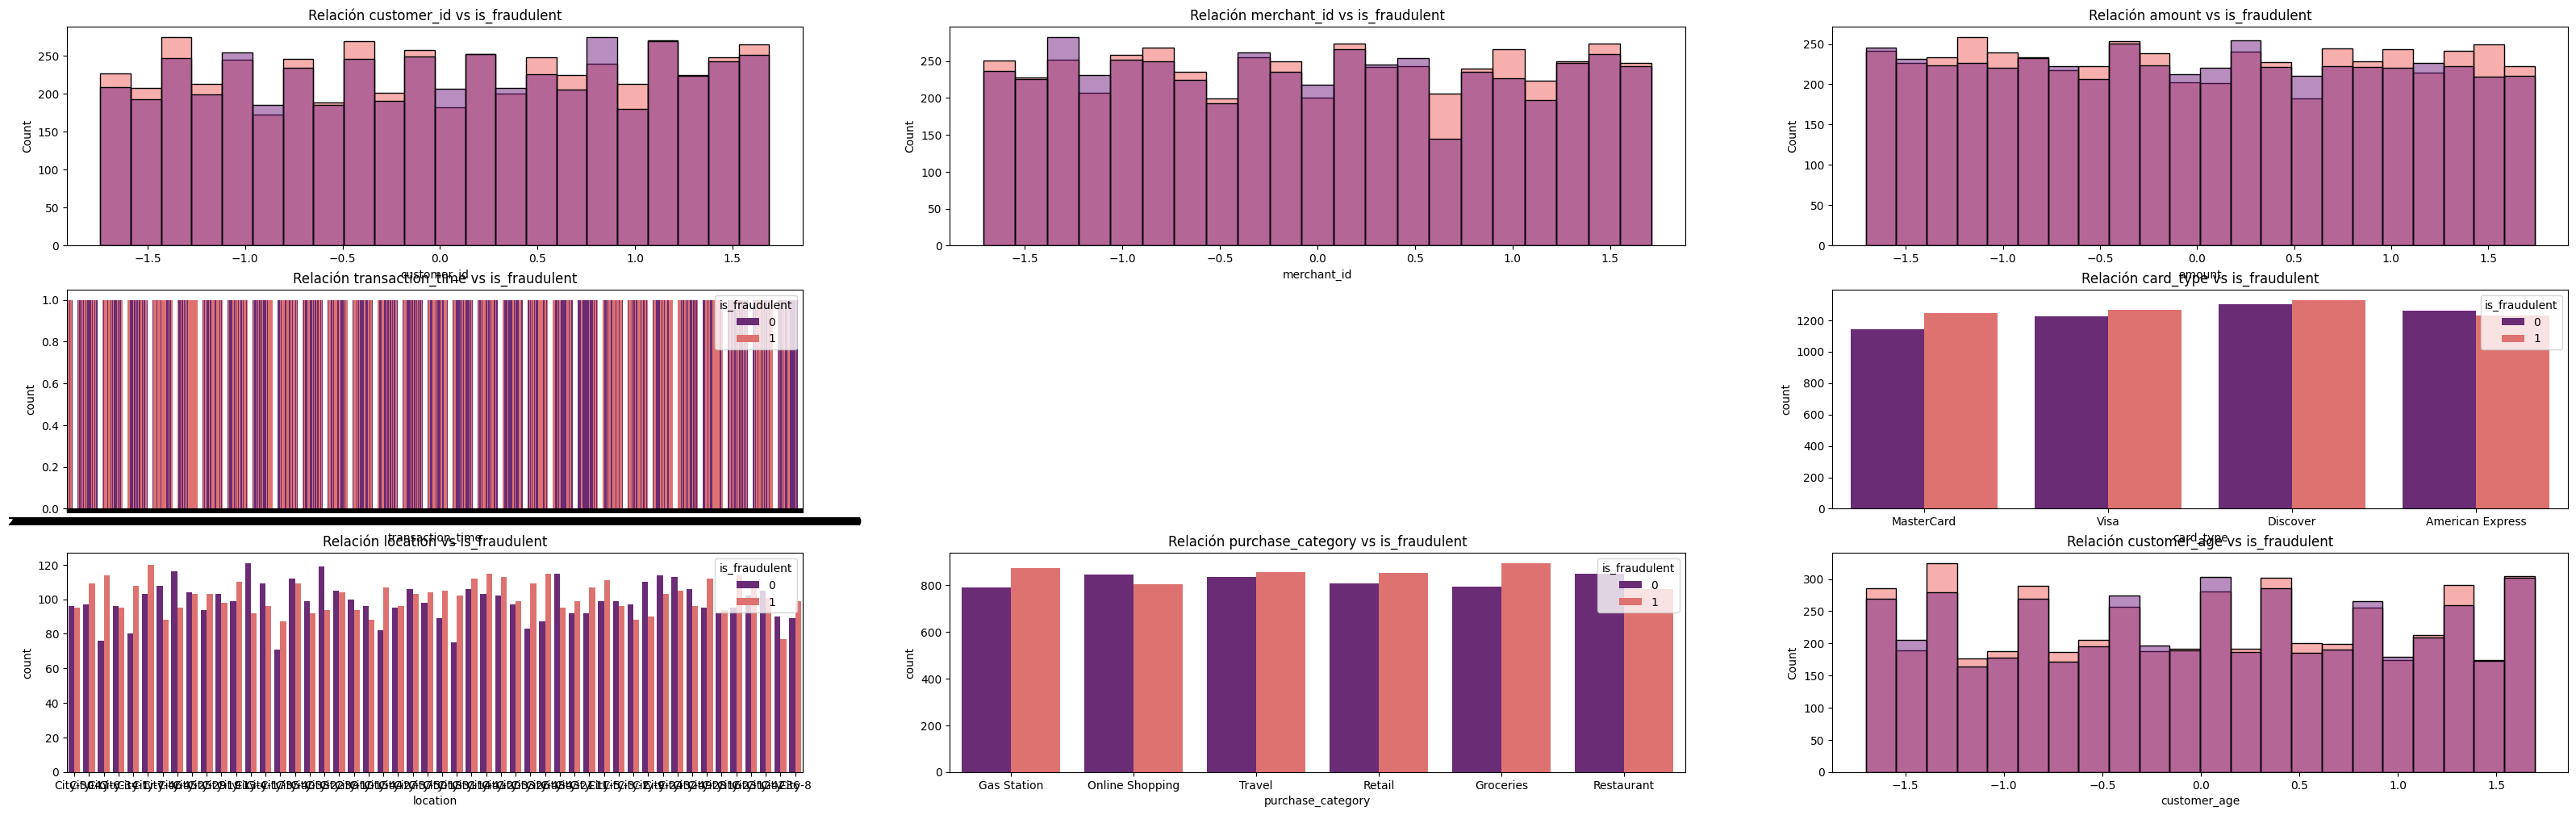

In [ ]:
# evaluamos la relación entre las variables independientes y dependientes
visualizador.plot_relacion(vr = "is_fraudulent")

In [14]:
# primero vamos a sacar los nombres de las columnas que son de tipo categórico
lista_col_categ = df.select_dtypes(include = "O").columns.tolist()
lista_col_categ

['transaction_time',
 'card_type',
 'location',
 'purchase_category',
 'transaction_description']

In [15]:
# # antes de nada debemos convertir la variable respuesta en numérica, por lo que asignaremos Yes con 1, y No con 0
# mapa_purchase = {"Yes": 1, "No": 0}
# df["is_fraudulent"] = df["is_fraudulent"].map(mapa_purchase)

# # sacamos la lista de columnas categóricas
# lista_col_categ = df.select_dtypes(include = ["O", "category"])

# for columna in lista_col_categ:

#     print(f"Analizando la relación entre is_fraudulent y {columna.upper()}")
#     # Inicializar la clase
#     analisis_chi2 = sc.AnalisisChiCuadrado(df, variable_predictora = columna, variable_respuesta = 'is_fraudulent')

#     # Generar la tabla de contingencia
#     tabla_contingencia = analisis_chi2.generar_tabla_contingencia()

#     # Realizar la prueba de Chi-cuadrado
#     resultado_chi2 = analisis_chi2.realizar_prueba_chi_cuadrado()

#     print("\n ##################################### \n")

In [16]:
print(df["is_fraudulent"].value_counts())
for columna in lista_col_categ:
    print(f"{columna}:\n{df[columna].value_counts()}\n")

is_fraudulent
1    5068
0    4932
Name: count, dtype: int64
transaction_time:
transaction_time
2023-01-01 02:46:23    1
2023-01-01 02:46:22    1
2023-01-01 02:46:21    1
2023-01-01 02:46:20    1
2023-01-01 02:46:19    1
                      ..
2023-01-01 00:00:04    1
2023-01-01 00:00:03    1
2023-01-01 00:00:02    1
2023-01-01 00:00:01    1
2023-01-01 00:00:00    1
Name: count, Length: 10000, dtype: int64

card_type:
card_type
Discover            2633
American Express    2494
Visa                2490
MasterCard          2383
Name: count, dtype: int64

location:
location
City-7     223
City-40    221
City-14    218
City-32    218
City-41    218
City-24    217
City-20    215
City-4     213
City-22    213
City-45    211
City-5     210
City-43    210
City-39    209
City-13    209
City-37    209
City-12    209
City-23    209
City-25    207
City-28    207
City-42    206
City-47    206
City-17    205
City-50    202
City-49    202
City-48    202
City-19    201
City-9     200
City-11    199
C

# Enocnding

In [ ]:
lista_col_categ = df.select_dtypes(include = "O").columns.tolist()
lista_col_categ 

['transaction_time',
 'card_type',
 'location',
 'purchase_category',
 'transaction_description']

In [17]:
valores_unicos = {}

# Iterar a través de las columnas categóricas y obtener los valores únicos
for col in lista_col_categ:
    valores_unicos[col] = df[col].unique().tolist()

# Mostrar los valores únicos
for col, valores in valores_unicos.items():
    print(f"Columna: {col}")
    print(f"Valores únicos: {valores}\n")

Columna: transaction_time
Valores únicos: ['2023-01-01 00:00:00', '2023-01-01 00:00:01', '2023-01-01 00:00:02', '2023-01-01 00:00:03', '2023-01-01 00:00:04', '2023-01-01 00:00:05', '2023-01-01 00:00:06', '2023-01-01 00:00:07', '2023-01-01 00:00:08', '2023-01-01 00:00:09', '2023-01-01 00:00:10', '2023-01-01 00:00:11', '2023-01-01 00:00:12', '2023-01-01 00:00:13', '2023-01-01 00:00:14', '2023-01-01 00:00:15', '2023-01-01 00:00:16', '2023-01-01 00:00:17', '2023-01-01 00:00:18', '2023-01-01 00:00:19', '2023-01-01 00:00:20', '2023-01-01 00:00:21', '2023-01-01 00:00:22', '2023-01-01 00:00:23', '2023-01-01 00:00:24', '2023-01-01 00:00:25', '2023-01-01 00:00:26', '2023-01-01 00:00:27', '2023-01-01 00:00:28', '2023-01-01 00:00:29', '2023-01-01 00:00:30', '2023-01-01 00:00:31', '2023-01-01 00:00:32', '2023-01-01 00:00:33', '2023-01-01 00:00:34', '2023-01-01 00:00:35', '2023-01-01 00:00:36', '2023-01-01 00:00:37', '2023-01-01 00:00:38', '2023-01-01 00:00:39', '2023-01-01 00:00:40', '2023-01-01 00

In [ ]:
target_encoder = TargetEncoder(lista_col_categ)
variables_encoded = target_encoder.fit_transform(df, df["is_fraudulent"])
variables_encoded

,customer_id,merchant_id,amount,transaction_time,is_fraudulent,card_type,location,purchase_category,customer_age,transaction_description
transaction_id,,,,,,,,,,
1,1.064619,-0.813351,0.275976,0.440861,0,0.521611,0.497382,0.524610,-0.068370,0.517856
2,-1.256722,0.087040,-1.054238,0.570969,1,0.507631,0.529126,0.486978,1.106492,0.536825
3,-1.637838,-0.536307,-1.279342,0.570969,1,0.521611,0.600000,0.524610,0.845411,0.506026
4,1.515029,-0.467046,0.917613,0.570969,1,0.504747,0.600000,0.505313,0.975952,0.525765
5,-0.529138,1.125952,-1.058191,0.570969,1,0.521611,0.497382,0.513546,-0.525261,0.523806
...,...,...,...,...,...,...,...,...,...,...
9996,0.163800,-0.951872,1.371555,0.570969,1,0.521611,0.497608,0.479829,-0.525261,0.548068
9997,0.059859,-0.847981,-1.699651,0.440861,0,0.521611,0.481651,0.513546,-0.133641,0.523362
9998,-0.355903,-0.570938,0.474300,0.440861,0,0.493986,0.574468,0.486978,-0.525261,0.451935


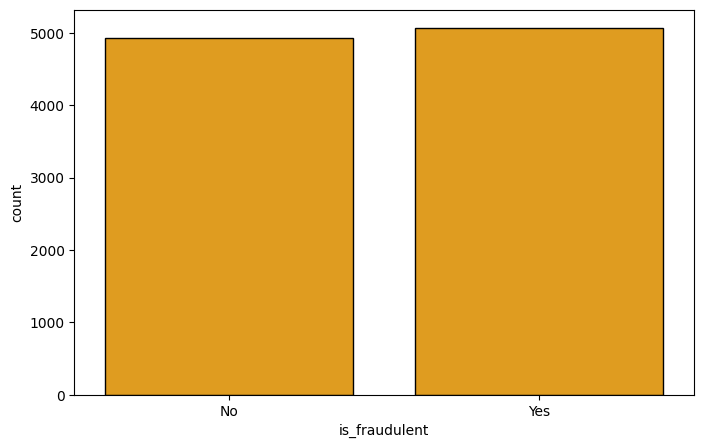

In [18]:
desbalanceo = sl.Desbalanceo(dataframe = df, variable_dependiente = "is_fraudulent")
desbalanceo.visualizar_clase()

In [19]:
df_balanceado_pandas = desbalanceo.balancear_clases_pandas("upsampling")
df_balanceado_pandas.head()

,customer_id,merchant_id,amount,transaction_time,is_fraudulent,card_type,location,purchase_category,customer_age,transaction_description
transaction_id,,,,,,,,,,
2,-1.256722,0.087040,-1.054238,2023-01-01 00:00:01,1,Visa,City-47,Online Shopping,1.106492,Purchase at Merchant-2053
3,-1.637838,-0.536307,-1.279342,2023-01-01 00:00:02,1,MasterCard,City-6,Gas Station,0.845411,Purchase at Merchant-2035
4,1.515029,-0.467046,0.917613,2023-01-01 00:00:03,1,Discover,City-6,Travel,0.975952,Purchase at Merchant-2037
5,-0.529138,1.125952,-1.058191,2023-01-01 00:00:04,1,MasterCard,City-34,Retail,-0.525261,Purchase at Merchant-2083
6,-0.667725,-1.021133,1.217186,2023-01-01 00:00:05,1,American Express,City-1,Gas Station,-0.068370,Purchase at Merchant-2021


In [26]:
df = df.drop(['transaction_time'], axis=1)

In [28]:
df_balanceado_imblearn = desbalanceo.balancear_clases_imblearn('RandomOverSampler')
df_balanceado_imblearn.head()

,customer_id,merchant_id,amount,transaction_time,card_type,location,purchase_category,customer_age,transaction_description,is_fraudulent
0,1.064619,-0.813351,0.275976,2023-01-01 00:00:00,MasterCard,City-30,Gas Station,-0.068370,Purchase at Merchant-2027,0
1,-1.256722,0.087040,-1.054238,2023-01-01 00:00:01,Visa,City-47,Online Shopping,1.106492,Purchase at Merchant-2053,1
2,-1.637838,-0.536307,-1.279342,2023-01-01 00:00:02,MasterCard,City-6,Gas Station,0.845411,Purchase at Merchant-2035,1
3,1.515029,-0.467046,0.917613,2023-01-01 00:00:03,Discover,City-6,Travel,0.975952,Purchase at Merchant-2037,1
4,-0.529138,1.125952,-1.058191,2023-01-01 00:00:04,MasterCard,City-34,Retail,-0.525261,Purchase at Merchant-2083,1


In [30]:
# llamamos al método para balancear las clases usando smote
df_balanceado_smote = desbalanceo.balancear_clases_smote()
df_balanceado_smote.head()

ValueError: could not convert string to float: '2023-01-01 00:00:00'

In [29]:
# llamamos a al método 'smote_tomek' para balancear las clases
df_balanceado_smote_tomek = desbalanceo.balancear_clases_smote_tomek()
df_balanceado_smote_tomek.head()

ValueError: could not convert string to float: '2023-01-01 00:00:00'

In [31]:
df_balanceado_smote_tomek.to_pickle("datos/financialbalanceado.pkl")

NameError: name 'df_balanceado_smote_tomek' is not defined